In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.settings import ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH

from gptchem.plotsettings import *

%matplotlib inline

## Load results

In [3]:
all_out = glob("out/**/*.pkl")

In [4]:
all_out = [load_pickle(p) for p in all_out]

In [5]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    try:
        res = {
            "train_size": out["train_size"],
            "frac_valid": out["frac_valid"],
            "accuracy": out["accuracy"],
            "f1_macro": out["f1_macro"],
            "f1_micro": out["f1_micro"],
            "kappa": out["kappa"],
            "num_classes": out["num_classes"],
            "target": out["target"],
        }
        extracted_res.append(res)
    except KeyError:
        pass

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["baseline"]["xgb_metrics"]["accuracy"],
        "f1_macro": out["baseline"]["xgb_metrics"]["f1_macro"],
        "f1_micro": out["baseline"]["xgb_metrics"]["f1_micro"],
        "kappa": out["baseline"]["xgb_metrics"]["kappa"],
        "num_classes": out["num_classes"],
        "target": out["target"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["baseline"]["tabpfn_metrics"]["accuracy"],
        "f1_macro": out["baseline"]["tabpfn_metrics"]["f1_macro"],
        "f1_micro": out["baseline"]["tabpfn_metrics"]["f1_micro"],
        "kappa": out["baseline"]["tabpfn_metrics"]["kappa"],
        "num_classes": out["num_classes"],
        "target": out["target"],
    }

    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [6]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [7]:
res

,train_size,frac_valid,accuracy,f1_macro,f1_micro,kappa,num_classes,target
0,10,1.000,0.228000,0.155294,0.228000,0.035000,5,"(logKH_CH4, CH4 Henry coefficient)"
1,20,0.000,0.000000,0.000000,0.000000,0.000000,5,"(logKH_CH4, CH4 Henry coefficient)"
2,20,1.000,0.508000,0.507614,0.508000,0.016000,2,"(logKH_CH4, CH4 Henry coefficient)"
3,10,1.000,0.556000,0.514614,0.556000,0.112000,2,"(logKH_CO2, CO2 Henry coefficient)"
4,50,0.000,0.000000,0.000000,0.000000,0.000000,2,"(logKH_CO2, CO2 Henry coefficient)"
5,10,1.000,0.556000,0.553937,0.556000,0.112000,2,"(logKH_CO2, CO2 Henry coefficient)"
6,100,1.000,0.576000,0.575973,0.576000,0.152000,2,"(logKH_CH4, CH4 Henry coefficient)"
7,500,1.000,0.328000,0.328652,0.328000,0.160000,5,"(logKH_CH4, CH4 Henry coefficient)"
8,10,0.000,0.000000,0.000000,0.000000,0.000000,2,"(logKH_CH4, CH4 Henry coefficient)"
9,10,1.000,0.536000,0.529221,0.536000,0.072000,2,"(logKH_CH4, CH4 Henry coefficient)"


In [8]:
grouped_res = res.groupby(["num_classes", "target", "train_size"]).agg(["mean", "std", sem])

In [9]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "target", "train_size"]).agg(
    ["mean", "std", sem]
)

In [10]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "target", "train_size"]).agg(
    ["mean", "std", sem]
)

In [11]:
grouped_res.loc[2, :]

frac_valid                      \
                                                    mean       std       sem   
target                             train_size                                  
(logKH_CH4, CH4 Henry coefficient) 10           0.714286  0.487950  0.184428   
                                   20           0.500000  0.577350  0.288675   
                                   50           0.666667  0.577350  0.333333   
                                   100          1.000000       NaN       NaN   
                                   200          1.000000       NaN       NaN   
                                   500          1.000000       NaN       NaN   
(logKH_CO2, CO2 Henry coefficient) 10           0.714286  0.487950  0.184428   
                                   20           0.500000  0.577350  0.288675   
                                   50           0.500000  0.707107  0.500000   
                                   200          1.000000       NaN       NaN   

                                               accuracy                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.381143  0.263015  0.099411   
                                   20          0.258000  0.297984  0.148992   
                                   50          0.357333  0.309460  0.178667   
                                   100         0.576000       NaN       NaN   
                                   200         0.516000       NaN       NaN   
                                   500         0.624000       NaN       NaN   
(logKH_CO2, CO2 Henry coefficient) 10          0.369714  0.255028  0.096391   
                                   20          0.259000  0.299108  0.149554   
                                   50          0.284000  0.401637  0.284000   
                                   200         0.568000       NaN       NaN   

                                               f1_macro                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.369164  0.253789  0.095923   
                                   20          0.257058  0.296872  0.148436   
                                   50          0.356619  0.308841  0.178309   
                                   100         0.575973       NaN       NaN   
                                   200         0.515061       NaN       NaN   
                                   500         0.623132       NaN       NaN   
(logKH_CO2, CO2 Henry coefficient) 10          0.360554  0.248117  0.093780   
                                   20          0.251597  0.290580  0.145290   
                                   50          0.283945  0.401558  0.283945   
                                   200         0.567557       NaN       NaN   

                                               f1_micro                      \
                                                   mean       std       sem   
target                             train_size                                 
(logKH_CH4, CH4 Henry coefficient) 10          0.381143  0.263015  0.099411   
                                   20          0.258000  0.297984  0.148992   
                                   50          0.357333  0.309460  0.178667   
                                   100         0.576000       NaN       NaN   
                                   200         0.516000       NaN       NaN   
                                   500         0.624000       NaN       NaN   
(logKH_CO2, CO2 Henry coefficient) 10          0.369714  0.255028  0.096391   
                                   20          0.259000  0.299108  0.149554   
                                   50          0.284000  0.401637  0.284000   
 

In [12]:
grouped_xgboost_res

accuracy            \
                                                               mean       std   
num_classes target                             train_size                       
2           (logKH_CH4, CH4 Henry coefficient) 10          0.505143  0.013607   
                                               20          0.577000  0.094678   
                                               50          0.629333  0.106006   
                                               100         0.744000       NaN   
                                               200         0.772000       NaN   
                                               500         0.792000       NaN   
            (logKH_CO2, CO2 Henry coefficient) 10          0.514857  0.039308   
                                               20          0.623000  0.056131   
                                               50          0.644000  0.005657   
                                               200         0.708000       NaN   
5           (logKH_CH4, CH4 Henry coefficient) 10          0.200000       NaN   
                                               20          0.272000  0.047441   
                                               50          0.330000  0.034176   
                                               100         0.372000       NaN   
                                               200         0.424000       NaN   
                                               500         0.496000       NaN   
            (logKH_CO2, CO2 Henry coefficient) 10          0.200000       NaN   
                                               20          0.200000       NaN   
                                               50          0.272000       NaN   
                                               200         0.284000       NaN   
                                               500         0.432000       NaN   

                                                                     f1_macro  \
                                                                sem      mean   
num_classes target                             train_size                       
2           (logKH_CH4, CH4 Henry coefficient) 10          0.005143  0.357942   
                                               20          0.047339  0.570679   
                                               50          0.061203  0.629039   
                                               100              NaN  0.743409   
                                               200              NaN  0.771909   
                                               500              NaN  0.791947   
            (logKH_CO2, CO2 Henry coefficient) 10          0.014857  0.371228   
                                               20          0.028065  0.620891   
                                               50          0.004000  0.641919   
                                               200              NaN  0.707771   
5           (logKH_CH4, CH4 Henry coefficient) 10               NaN  0.066667   
                                               20          0.023721  0.274516   
                                               50          0.017088  0.330912   
                                               100              NaN  0.374347   
                                               200              NaN  0.420356   
                                               500              NaN  0.484021   
            (logKH_CO2, CO2 Henry coefficient) 10               NaN  0.066667   
                                               20               NaN  0.191643   
                                               50               NaN  0.278736   
                                               200              NaN  0.282622   
                                               500              NaN  0.429590   

                                                                               \
                                                                std       sem   
num_cla

In [13]:
grouped_res.loc[2, :].index[0][0]

('logKH_CH4', 'CH4 Henry coefficient')

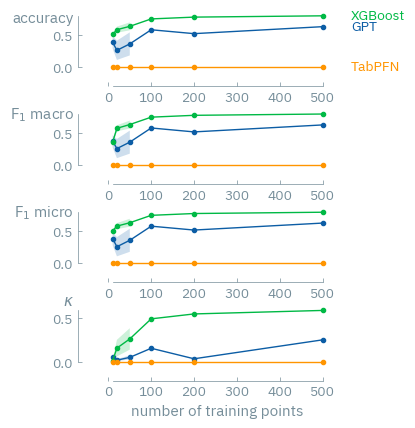

In [14]:

fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
       grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index, 
       np.stack(
        [
        grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
         grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        ]
       ).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)
fig.savefig("logKHCH4-classification_results_binary.pdf", bbox_inches="tight")

In [15]:
find_learning_curve_intersection(
    grouped_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CH4", "CH4 Henry coefficient"), :]["f1_macro"]["mean"],
    )[0],
) / 10

1.0571919097545301

In [16]:
find_learning_curve_intersection(
    grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :]["f1_macro"]["mean"],
    )[0],
) / 10

0.8377760469418745

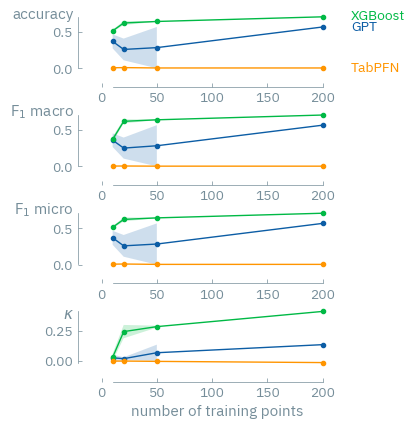

In [17]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    range_frame(
        ax[i],
       grouped_res.loc[2, ("logKH_CO2",  "CO2 Henry coefficient"), :].index, 
       np.stack(
        [
        grouped_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
         grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
            grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        ]
       ).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[2, ("logKH_CO2", "CO2 Henry coefficient"), :][metric]["sem"],
        alpha=0.2,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)

fig.savefig("logKHCO2-classification_results_binary.pdf", bbox_inches="tight")

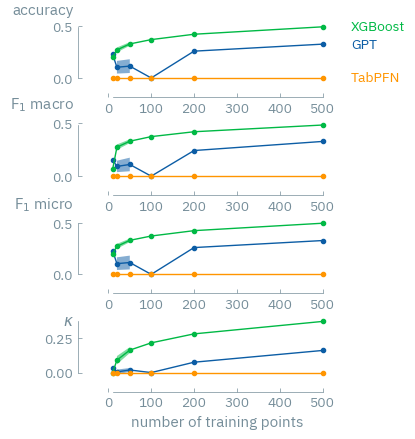

In [18]:

fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )
    range_frame(
        ax[i],
       grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index, 
       np.stack(
        [
        grouped_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
         grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
            grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        ]
       ).flatten()
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_xgboost_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :].index,
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        - grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["mean"]
        + grouped_tabpfn_res.loc[5, ("logKH_CH4", "CH4 Henry coefficient"), :][metric]["sem"],
        alpha=0.5,
    )

ylabel_top("accuracy", ax=ax[0], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], x_pad=0.05, y_pad=0.06)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], x_pad=0.05, y_pad=0.06)
ylabel_top(r"$\kappa$", ax=ax[3], x_pad=0.05, y_pad=0.06)
ax[-1].set_xlabel("number of training points", labelpad=4)
matplotx.line_labels(ax=ax[0])
plt.subplots_adjust(hspace=.6, top=1, bottom=.2)

fig.savefig("logKHCH4-classification_results_5.pdf", bbox_inches="tight")